In [1]:
import os
import torch
import numpy as np
import json 
import random

from collections import deque
import pcgym
from tqdm import tqdm
from agent_v1 import Agent
from utils import Save_model_logfile

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="runs/DeepDQN_6")  # Specify log directory

In [2]:

nsteps = 100
T = 25
SP = {'Ca': [0.85 for _ in range(int(nsteps/2))] + [0.9 for _ in range(int(nsteps/2))]}


action_space = {'low': np.array([290]), 'high': np.array([302])}
observation_space = {'low': np.array([0.7,300,0.8]),'high': np.array([1,350,0.9])}
r_scale ={
    'Ca': 1e3 #Reward scale for each state
}

# Construct the environment parameter dictionary

env_params = {
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'SP':SP, # Setpoint
    'o_space' : observation_space, # Observation space
    'a_space' : action_space, # Action space
    'x0': np.array([0.8,330,0.8]), # Initial conditions 
    'model': 'cstr_ode', # Select the model
    'r_scale': r_scale, # Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, # Normalise the actions
    'normalise_o':True, # Normalise the states,
    'noise':True, # Add noise to the states
    'integration_method': 'casadi', # Select the integration method
    'noise_percentage':0.001 # Noise percentage
}


env_name = 'cstr_ode'
# Create environment
env = pcgym.make_env(env_params)

/Users/chen/Desktop/DQN/venv3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chen/Desktop/DQN/venv3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [3]:
#---- Runner Initialization ----#
time_step = 0
i_episode = 0
max_ep_len = 100
    
log_running_reward = 0
log_running_episodes = 0

#---- NAF hyperparameters ----#
frames=max_ep_len*1500      # Total number of time_steps 

update_every=10              # frequency to update the Q-network
n_updates= 1                # number of updates for each Q-network optimization
n_multistart= 12            # number of re-start for Q-value maximization
batch_size= 84             # size of minibatch per optimization
buffer_size = 30000         # size of the buffer 

n_step_bootstrapping = 1    # number of steps bootstrapping
layer1_dim=128              # size of the hidden layer1
layer2_dim=64               # size of the hidden layer2
learning_rate=1e-3          # step size for the Adam optimizer
tau=0.001                   # weigthing in the soft-update the target policy     
gamma=0.99                  # dicounted parameter in bellmans equation
seed=0                      # random seed
action_dim  = env.action_space.shape[0]
state_dim   = env.observation_space.shape[0]
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#---- Update Frequency ----#
log_freq = 101             # log avg reward in the interval (in num timesteps)
save_model_freq = max_ep_len * 100  # save model frequency (in num timesteps)

bounds = torch.tensor([-1,1]).reshape(-1,2)

#---- Agent ----#
agent = Agent(bounds,state_dim,action_dim,layer1_dim,layer2_dim,batch_size,buffer_size,
              tau,gamma,learning_rate,update_every,n_updates,n_step_bootstrapping,
              n_multistart,seed,writer)


#---- saving path ----#
algo_name = 'DQN'
Save = Save_model_logfile(algo_name,env_name,seed=seed)

log_f_name = Save.log_path()
checkpoint_path = Save.model_path()
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')

# Initialize the tqdm progress bar
progress_bar = tqdm(total=frames, desc="Program Progress", unit="step")


Program Progress:   0%|          | 0/150000 [00:00<?, ?step/s]

In [4]:
# Initialize state and counters
state, _ = env.reset()
while time_step <= frames:
    
    state, _ = env.reset()
    current_episode_reward = 0
    
    for _ in range(1, max_ep_len + 1):
        s_ = torch.from_numpy(state).float().to(device)
        _, action = agent.action_selection(s_,agent.network,True,time_step)
        action = action.squeeze().numpy().reshape((agent.action_dim,))
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        
        time_step += 1
        current_episode_reward += reward
        progress_bar.update(1)
        
        # Log to TensorBoard
        if time_step % log_freq == 0:
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)
            
            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()
            
            log_running_reward = 0
            log_running_episodes = 0
            progress_bar.set_postfix(reward=log_avg_reward)
            writer.add_scalar('Average Reward', log_avg_reward, time_step)  
            
        # Save model weights
        if time_step % save_model_freq == 0:
            agent.save(checkpoint_path)
            
    log_running_reward += current_episode_reward
    log_running_episodes += 1
    i_episode += 1

env.close()
log_f.close()
writer.close()  
progress_bar.close()

/Users/chen/Desktop/DQN/venv3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chen/Desktop/DQN/venv3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
Program Progress: 150100step [1:21:23, 30.73step/s, reward=-64.2]                          


In [5]:


update_every=5   # frequency to update the Q-network
n_updates= 1               # number of updates for each Q-network optimization
n_multistart= 12            # number of re-start for Q-value maximization
batch_size= 64              # size of minibatch per optimization
buffer_size = 10000          # size of the buffer 

n_step_bootstrapping = 1    # number of steps bootstrapping
layer1_dim=128              # size of the hidden layer1
layer2_dim=64               # size of the hidden layer2
learning_rate=1e-3          # step size for the Adam optimizer
tau=0.001                   # weigthing in the soft-update the target policy     
gamma=0.99                  # dicounted parameter in bellmans equation
seed=0                      # random seed
action_dim  = env.action_space.shape[0]
state_dim   = env.observation_space.shape[0]
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


bounds = torch.tensor([-1,1]).reshape(-1,2)

#---- Agent ----#
agent_reload = Agent(bounds,state_dim,action_dim,layer1_dim,layer2_dim,batch_size,buffer_size,
              tau,gamma,learning_rate,update_every,n_updates,n_step_bootstrapping,
              n_multistart,seed,writer)

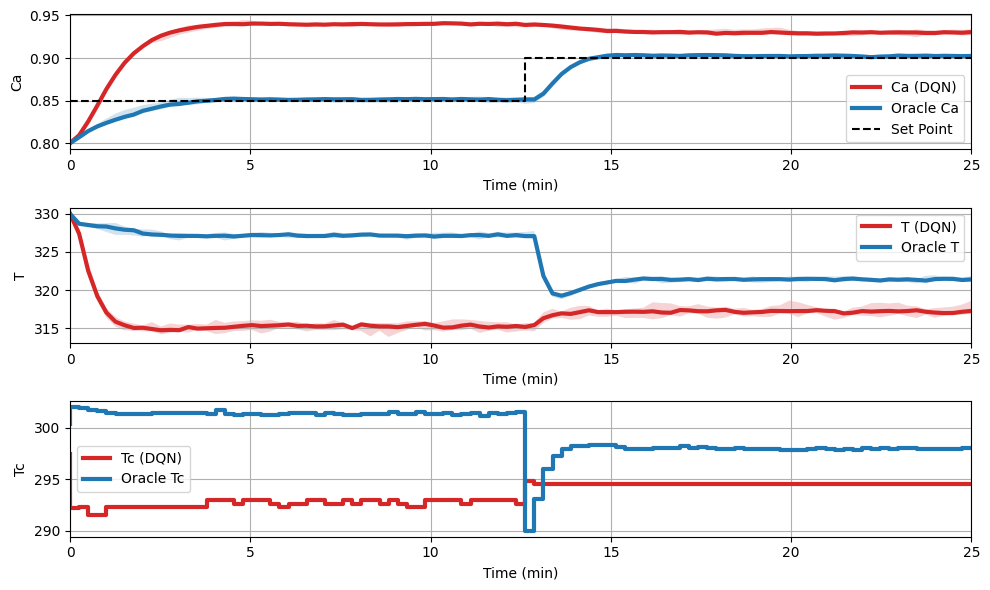

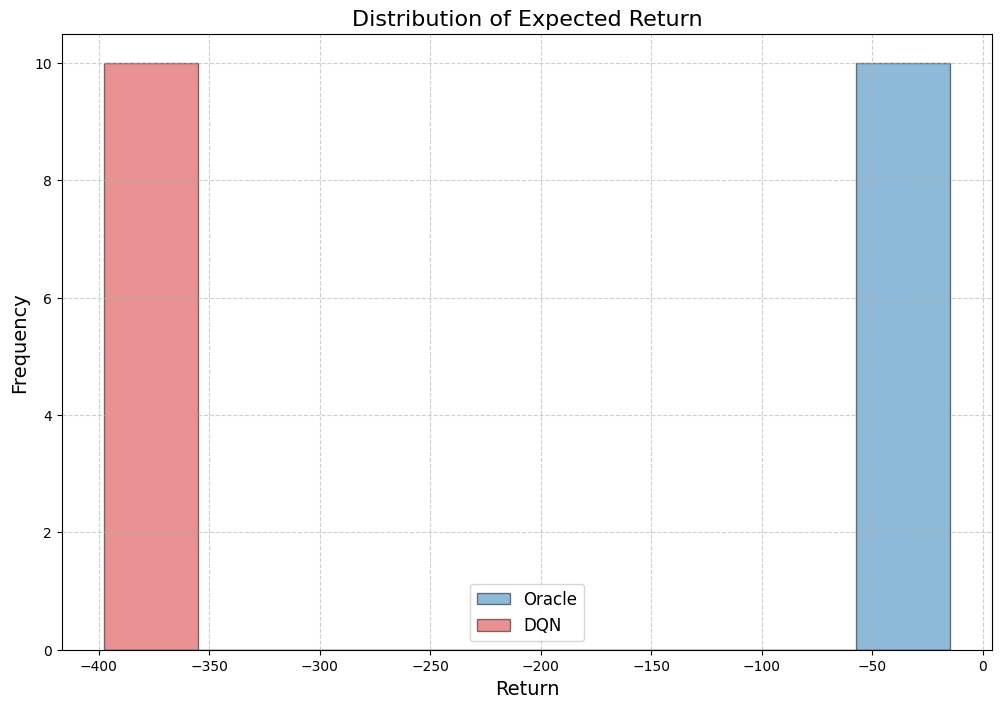

In [8]:
# Load the saved state_dict from the .pth file
checkpoint_path = "DQN_preTrained/cstr_ode/DQN_cstr_ode_0_10.pth"
agent_reload.load(checkpoint_path)
evaluator, data = env.plot_rollout({'DQN':agent_reload},reps=10,oracle = True, dist_reward=True, MPC_params={'N':15,'R':5})

- create folder based on number of folder
- save model with name of episode into folder.